In [54]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from tqdm import trange
seed = 42

## Load and concat data

In [56]:
df_target = pd.read_csv('data/job_interest_target.csv')
df_raw = pd.read_csv('data/job_interest_data.csv')
df_merge_train = pd.merge(left=df_raw, right=df_target, on='enrollee_id')

test_data = pd.read_csv('data/X_test.csv')
test_target = pd.read_csv('data/y_test.csv')
df_merge_test = pd.merge(left=test_data, right=test_target, on='enrollee_id')
df_raw = pd.concat([df_merge_train, df_merge_test])
df_raw.target = df_raw.target.astype(int)
df_raw

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,25298,city_138,0.836,Male,No relevent experience,Full time course,High School,NaN,5,100-500,Pvt Ltd,1,45,0
1,4241,city_160,0.920,Male,No relevent experience,Full time course,High School,NaN,5,NaN,NaN,1,17,1
2,24086,city_57,0.866,Male,No relevent experience,no_enrollment,Graduate,STEM,10,NaN,NaN,1,50,0
3,26773,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,>4,135,0
4,32325,city_143,0.740,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701,3601,city_103,0.920,Male,Has relevent experience,Part time course,Graduate,STEM,8,10000+,Pvt Ltd,2,8,0
6702,2745,city_71,0.884,Male,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,1,8,1
6703,18520,city_138,0.836,Male,No relevent experience,Part time course,Masters,Humanities,19,10/49,Pvt Ltd,4,20,0
6704,10067,city_136,0.897,Male,No relevent experience,Full time course,Masters,STEM,5,NaN,NaN,never,86,0


In [48]:
pd.concat([df_raw.dtypes, df_raw.nunique()], axis=1)

,0,1
enrollee_id,int64,19158
city,object,123
city_development_index,float64,93
gender,object,3
relevent_experience,object,2
enrolled_university,object,3
education_level,object,5
major_discipline,object,6
experience,object,22
company_size,object,8


## Data preprocessing

In [49]:
df = df_raw.copy()

In [50]:
dummy_cols = df.nunique()[df.nunique() < 10].index.drop('target')

for col in dummy_cols:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    df = df.drop(col, axis=1)

In [57]:
for col in df.select_dtypes('object'):
    df[col] = df[col].astype('category').cat.codes
df

,enrollee_id,city,city_development_index,experience,training_hours,target,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,25298,31,0.836,15,45,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1,4241,49,0.920,15,17,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,24086,89,0.866,1,50,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,26773,48,0.910,21,135,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
4,32325,37,0.740,15,17,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701,3601,5,0.920,18,8,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
6702,2745,99,0.884,15,8,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6703,18520,31,0.836,10,20,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
6704,10067,30,0.897,15,86,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## EDA

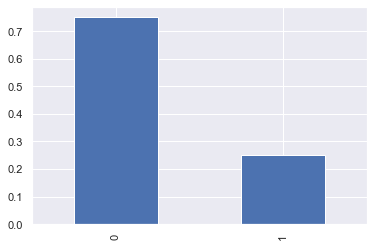

In [53]:
(df.target.value_counts()/len(df)).plot(kind='bar')
plt.savefig('images/class_imbalance_attrition.png', dpi=100)

## Train-test split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df.target, test_size=0.2, stratify=df.target)

In [13]:
f1 = {}
recall = {}
precision = {}

In [14]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=7)
x_train_over, y_train_over = sm.fit_resample(x_train, y_train)
print(x_train_over.shape)

clf = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_leaf=5)
clf.fit(x_train_over, y_train_over)
preds = clf.predict(x_test)
print(preds.shape)
f1['SMOTE'] = f1_score(y_test, preds)
recall['SMOTE'] = recall_score(y_test, preds)
precision['SMOTE'] = precision_score(y_test, preds)


(23008, 44)
(3832,)


In [15]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(x_train, y_train)
print(X_train_un.shape)

clf = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_leaf=5)
clf.fit(X_train_un, y_train_un)
preds = clf.predict(x_test)
print(preds.shape)

f1['Undersampling'] = f1_score(y_test, preds)
recall['Undersampling'] = recall_score(y_test, preds)
precision['Undersampling'] = precision_score(y_test, preds)

(7644, 44)
(3832,)


In [145]:
print(x_train.shape)
clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=50, min_samples_leaf=5)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(preds.shape)

f1['Class Weights'] = f1_score(y_test, preds)
recall['Class Weights'] = recall_score(y_test, preds)
precision['Class Weights'] = precision_score(y_test, preds)

(15326, 44)
(3832,)


In [148]:
print(x_train.shape)
clf = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_leaf=5)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(preds.shape)

f1['Unbalanced'] = f1_score(y_test, preds)
recall['Unbalanced'] = recall_score(y_test, preds)
precision['Unbalanced'] = precision_score(y_test, preds)

(15326, 44)
(3832,)


In [81]:
import numpy as np

def calculate_score(clf, x_train, y_train, x_test, y_test, name):
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    return {
        'model': name,
        'f1_score': f1_score(y_test, preds), 
        'recall': recall_score(y_test, preds), 
        'precision': precision_score(y_test, preds)
    }

def calculate_metrics(model, df):
    x_train, x_test, y_train, y_test = train_test_split(
        df.drop('target', axis=1),
        df.target, 
        test_size=0.2, 
        stratify=df.target,
        random_state=seed,
    )

    if model == 'classweights':
        clf = RandomForestClassifier(class_weight='balanced', random_state=seed, n_estimators=50, 
                                     min_samples_leaf=5, n_jobs=-1)

    else:
        clf = RandomForestClassifier(random_state=seed, n_estimators=50, min_samples_leaf=5, n_jobs=-1)

    if model == 'smote':
        sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=seed)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    elif model == 'undersampling': 
        rus = RandomUnderSampler(random_state=seed)
        x_train, y_train = rus.fit_resample(x_train, y_train)
    elif model == 'oversampling':
        ros = RandomOverSampler(random_state=seed)
        x_train, y_train = ros.fit_resample(x_train, y_train)

    return calculate_score(clf, x_train, y_train, x_test, y_test, model)


def loop_models(df):
    results = []
    for i in trange(10):
        idxs = df.loc[df.target == 1].sample(frac=i/10).index.values
        df_dropped = df.drop(idxs)
        for j in ['unbalanced', 'smote', 'undersampling', 'oversampling', 'classweights']:
            results.append({
                'frac_dropped': i/10, 
                'abs(y)': len(df_dropped.loc[df_dropped.target == 1]), 
                **calculate_metrics(model=j, df=df_dropped)}
                )
    return results

res = loop_models(df)

 70%|███████   | 7/10 [00:09<00:03,  1.29s/it]/Users/baukebrenninkmeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|████████  | 8/10 [00:10<00:02,  1.20s/it]/Users/baukebrenninkmeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████ | 9/10 [00:11<00:01,  1.13s/it]/Users/baukebrenninkmeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

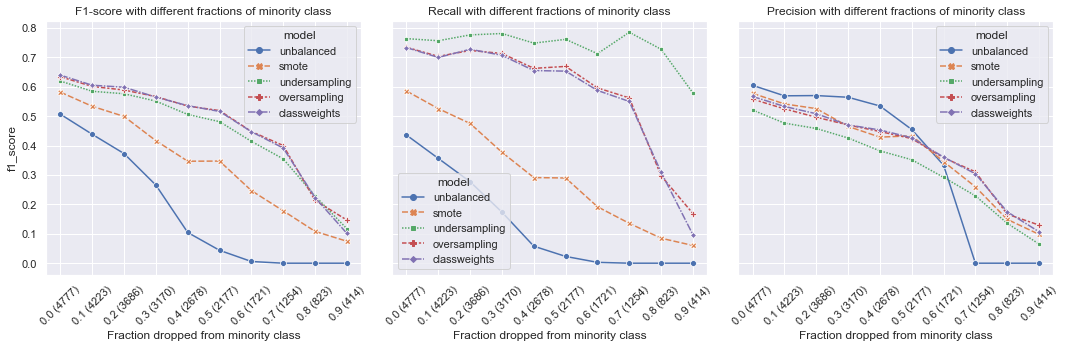

In [82]:
res_df = pd.DataFrame(res)
sns.set()

res_df['frac_dropped'] = res_df.frac_dropped.astype(str) + ' (' + res_df['abs(y)'].astype(str) + ')'

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)

ax_idx = 0
sns.lineplot(data=res_df, y='f1_score', x='frac_dropped', hue='model', ax=axes[ax_idx], markers=True, style='model')
axes[ax_idx].title.set_text('F1-score with different fractions of minority class')
axes[ax_idx].set_xlabel('Fraction dropped from minority class')
axes[ax_idx].tick_params(axis='x', labelrotation = 45)

ax_idx = 1
sns.lineplot(data=res_df, y='recall', x='frac_dropped', hue='model', ax=axes[ax_idx], markers=True, style='model')
axes[ax_idx].title.set_text('Recall with different fractions of minority class')
axes[ax_idx].set_xlabel('Fraction dropped from minority class')
axes[ax_idx].tick_params(axis='x', labelrotation = 45)

ax_idx = 2
sns.lineplot(data=res_df, y='precision', x='frac_dropped', hue='model', ax=axes[ax_idx], markers=True, style='model')
axes[ax_idx].title.set_text('Precision with different fractions of minority class')
axes[ax_idx].set_xlabel('Fraction dropped from minority class')
axes[ax_idx].tick_params(axis='x', labelrotation = 45)

fig.tight_layout()

fig.savefig('images/class_weights_results.png', dpi=100)

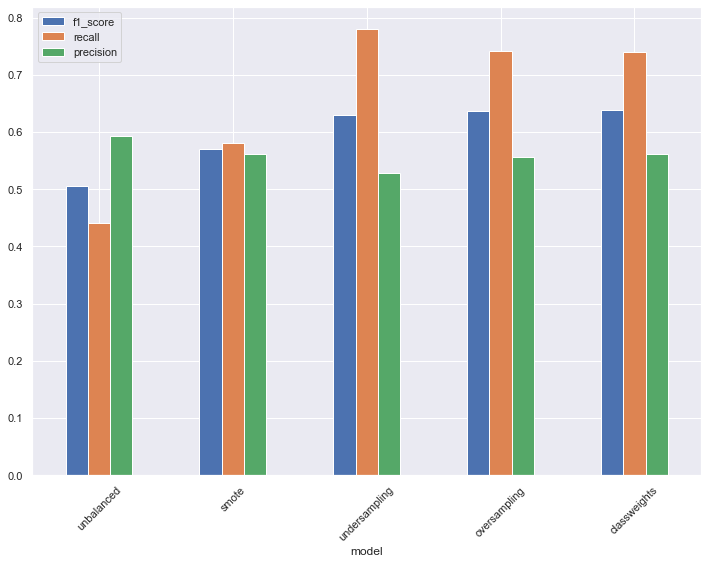

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))
res_df.drop('abs(y)', axis=1).loc[res_df.frac_dropped == '0.0 (4777)'].plot.bar(x='model', ax=ax)
ax.tick_params(axis='x', labelrotation = 45)
plt.savefig('images/imbalanced_learning_performance.png', dpi=100)
plt.tight_layout()

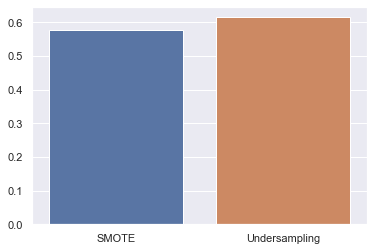

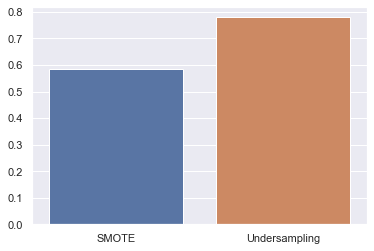

<AxesSubplot:>

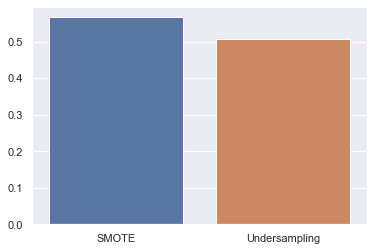

In [60]:
import seaborn as sns
sns.barplot(x=list(f1.keys()), y=list(f1.values()))
plt.show()
sns.barplot(x=list(recall.keys()), y=list(recall.values()))
plt.show()
sns.barplot(x=list(precision.keys()), y=list(precision.values()))
